In [1]:
import pickle
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(30, 256)
        self.conv2 = GCNConv(256, 256)
        self.conv3 = GCNConv(256, 256)
        self.conv4 = GCNConv(256, 256)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = global_max_pool(x, data.batch)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [3]:
def custom_collate(batch):
    data_list, target_list = zip(*batch)
    batch_data = Batch.from_data_list(data_list)
    batch_target = torch.stack(target_list)
    return batch_data, batch_target

Dataset :  AI+Human
Epoch 1, Validation Loss: 0.3260162339114855
Epoch 2, Validation Loss: 0.2031230909031876
Epoch 3, Validation Loss: 0.15139311028479
Epoch 4, Validation Loss: 0.17031329169134185
Epoch 5, Validation Loss: 0.10353522681541907
Epoch 6, Validation Loss: 0.08088066321572004
Epoch 7, Validation Loss: 0.07242877209944025
Epoch 8, Validation Loss: 0.06342188853445418
Epoch 9, Validation Loss: 0.0585952661811558
Epoch 10, Validation Loss: 0.05479923012595827
Epoch 11, Validation Loss: 0.04987287331128041
Epoch 12, Validation Loss: 0.06257666655200875
Epoch 13, Validation Loss: 0.05812487891030127
Epoch 14, Validation Loss: 0.06880941314728523
Epoch 15, Validation Loss: 0.04414290118883623
Epoch 16, Validation Loss: 0.03685070851801671
Epoch 17, Validation Loss: 0.0364394558542407
Epoch 18, Validation Loss: 0.04326446549030561
Epoch 19, Validation Loss: 0.03191321049406464
Epoch 20, Validation Loss: 0.03185873779445942
Epoch 21, Validation Loss: 0.030650434487563244
Epoch 22

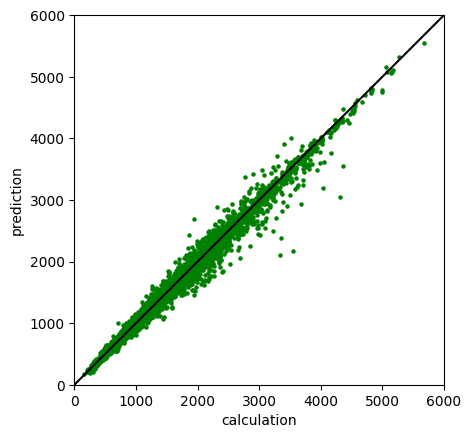

In [4]:
torch.manual_seed(0)

target_data = "bertzct"
scaler = StandardScaler()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
    
for d in ["AI+Human"]:
    torch.manual_seed(0)
    print('Dataset : ', d)
    dataset = d

    with open(f'data_{dataset}/data_train_list.pkl', 'rb') as f:
        data_train_list = pickle.load(f)
    with open(f'data_{dataset}/data_val_list.pkl', 'rb') as f:
        data_val_list = pickle.load(f)
    with open(f'data_{dataset}/data_test_list.pkl', 'rb') as f:
        data_test_list = pickle.load(f)
    with open(f'data_{dataset}/target_train_{target_data}.pkl', 'rb') as f:
        target_train = pickle.load(f)
    with open(f'data_{dataset}/target_val_{target_data}.pkl', 'rb') as f:
        target_val = pickle.load(f)
    with open(f'data_{dataset}/target_test_{target_data}.pkl', 'rb') as f:
        target_test = pickle.load(f)
        
    target_train = scaler.fit_transform(np.array(target_train).reshape(-1, 1)).flatten()
    target_val = scaler.transform(np.array(target_val).reshape(-1, 1)).flatten()
    target_test = scaler.transform(np.array(target_test).reshape(-1, 1)).flatten()
    target_train = torch.tensor(target_train, dtype=torch.float32)
    target_val = torch.tensor(target_val, dtype=torch.float32)
    target_test = torch.tensor(target_test, dtype=torch.float32)

    train_loader = DataLoader(list(zip(data_train_list, target_train)), batch_size=128, collate_fn=custom_collate)
    val_loader = DataLoader(list(zip(data_val_list, target_val)), batch_size=128, collate_fn=custom_collate)
    test_loader = DataLoader(list(zip(data_test_list, target_test)), batch_size=128, collate_fn=custom_collate)

    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    early_stopping_patience = 30
    best_val_loss = float('inf')
    patience_counter = 0

    loss_train = []
    for epoch in range(100):
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())
        
        model.eval()
        val_loss = 0
        total_size = 0
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                out = model(data)
                loss = criterion(out, target.view(-1, 1))
                val_loss += loss.item() * data.size(0)
                total_size += data.size(0)
        val_loss /= total_size
        
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'data_{dataset}/model_{dataset}_sc.pth')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    model.load_state_dict(torch.load(f'data_{dataset}/model_{dataset}_sc.pth'))
    model.eval()
    
    pred_train = []
    for data, target in train_loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred_train.append(out.cpu().numpy())
    pred_train = np.concatenate(pred_train)

    pred_test = []
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred_test.append(out.cpu().numpy())
    pred_test = np.concatenate(pred_test)

    pred_train = scaler.inverse_transform(pred_train)
    pred_test = scaler.inverse_transform(pred_test)
    target_train = scaler.inverse_transform(np.array(target_train).reshape(-1, 1)).flatten()
    target_test = scaler.inverse_transform(np.array(target_test).reshape(-1, 1)).flatten()

    print('R2 train:', metrics.r2_score(target_train, pred_train))
    print('R2 test:', metrics.r2_score(target_test, pred_test))
    
    n = 6000
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(range(0, n+1), range(0, n+1), c='black')
    plt.scatter(target_test, pred_test, c='green', s=5)
    plt.xlim(0, n)
    plt.ylim(0, n)
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel("calculation")
    plt.ylabel("prediction")
    plt.show()
    fig.savefig(f'data_{dataset}/source_sc.pdf')